In [6]:
import contextlib
from datetime import datetime
import requests as req
from typing import List
import requests as req
from statistics import mean
import itertools
from dtw import *

In [156]:
class ChartCollectorAPI():
    def __init__(self):
        self.charts={}
    
    def get_chart(self,symbol:str,timeframe:int=30,charts:List[str]=None,range:str="1mo") -> list:
        headers = {
            'x-api-key': "mTd2MNVwEe3WFgj5PQ66Tbpq0CyeP8Q7ESjpmYZ2"
        }
        
        url = f"https://yfapi.net/v8/finance/chart/{symbol}?comparisons="
        if charts:
            for asset in charts:
                url+= asset
                if asset != (len(charts) - 1):
                    url+="%2C"
        
        url+=f"&range={range}&region=US&interval=1d&lang=en&events=div%2Csplit"
            
        response = req.request("GET", url, headers=headers)
        
        try:
            response = response.json()["chart"]["result"][0]
            timesamps = response["timestamp"]
            
            reference = response["indicators"]["quote"][0]["close"]
            
            # Adding reference chart
            if symbol not in self.charts:
                self.charts[symbol]=[{"date":datetime.fromtimestamp(int(timestamp)), "close":close} for timestamp, close in zip(timesamps, reference)]
            
            
            if charts:
                comparison = response["comparisons"]
                # Adding the comparisons charts
                for value in comparison:
                    if value["symbol"] not in self.charts:
                        self.charts[value["symbol"]]=[{"date":datetime.fromtimestamp(int(timestamp)), "close":close} for timestamp, close in zip(timesamps, value["close"])]


            
        
        except Exception as error:
            print(response.json())
        
        
    """
    Methode pour charger le graphique d'un actif depuis l'api
    On verifie si l'actif n'a pas encore été chargé
    """
    def loading(self,list_actifs:List[str]):
        for actif in list_actifs:
            if actif not in self.charts:
               self.charts[actif]=self.get_chart(actif)
        
    """Methode qui sauvegarde les differents graphiques de comparaisons des différents actifs passés dans une liste en parametre
    Print dans la console les differentes distances en fonction de l'algorithme utilisé.
    """
    def resultats_rapports(self,actif_reference,charts) -> dict:
        results = {}
        
        
        # On recupere le dernier mois de données du graph de reference
        chart_reference = [value['close'] for value in charts[actif_reference]]
        
        data_length = int(len(chart_reference)/3)
        chart_reference = chart_reference[-data_length:]
        

        # On le compare aux autres graphiques
        for actif_comparaison in charts:
            if actif_comparaison != actif_reference:
                # On va réduire la fenetre des actifs de comparaison 
                chart_comparison = [value['close'] for value in charts[actif_comparaison]]

                for i in range(2):
                    if i ==0:
                        # Premier mois de données
                        comparison = chart_comparison[:data_length]
                        month = "1"
                        current_data = chart_comparison[data_length:data_length]
                    else:
                        # Deuxieme mois de données
                        comparison = chart_comparison[data_length:data_length*2]
                        month = "2"
                        current_data = chart_comparison[-data_length:]
                    

                    results[f"DTW rapport moyenne {actif_reference} /  {actif_comparaison} {month} tiers"] = {
                        "value":self.dynamic_time_warping_par_rapport_moyenne(chart_reference,comparison)["distance moyenne"],
                        "actif_reference":actif_reference,
                        "actif_comparaison":actif_comparaison,
                        "chart_reference":chart_reference,
                        "current_data":current_data,
                        "chart_comparison":comparison
                        }
                    
                    
            

            
        
        return results                



    
    def distance_point_par_point_rapport_moyenne(self,chart_reference,chart_comparison):          
         # Adapte les amplitudes des courbes pour pouvoir les comparer
        
        ## On les ramene à 1 en faisant le rapport par rapport à leur moyenne
        rearange_reference = [value / mean(chart_reference) for value in chart_reference]
        rearange_comparison = [value / mean(chart_comparison) for value in chart_comparison]

        # On calcule les differentes distances entre les points des deux courbes
        distances = [
            abs(rearange_reference[i] - rearange_comparison[i])
            for i in range(len(rearange_reference))
        ]

        return {"distance moyenne":round(mean(distances),2)}
    

    
    def dynamic_time_warping_par_rapport_moyenne(self,chart_reference,chart_comparison):
        # Adapte les amplitudes des courbes pour pouvoir les comparer
        
        ## On les ramene à 1 en faisant le rapport par rapport à leur moyenne
        rearange_reference = [value / mean(chart_reference) for value in chart_reference]
        rearange_comparison = [value / mean(chart_comparison) for value in chart_comparison]


        # OO method call chain
        warping = dtw(rearange_comparison, rearange_reference, keep_internals=True, step_pattern=rabinerJuangStepPattern(6, "c"))

        
        return {"distance moyenne":round(warping.distance/len(chart_comparison),2)}
    


https://yfapi.net/v8/finance/chart/AAPL?comparisons=MSFT%2CAPPL&range=1mo&region=US&interval=1d&lang=en&events=div%2Csplit

In [28]:
Charts = ChartCollectorAPI()
Charts.get_chart(symbol="AAPL",charts=["AMC","AMD","TLRY","MSFT"],range="3mo")


In [29]:
print(Charts.charts)

{'AAPL': [{'date': datetime.datetime(2021, 12, 29, 15, 30), 'close': 179.3800048828125}, {'date': datetime.datetime(2021, 12, 30, 15, 30), 'close': 178.1999969482422}, {'date': datetime.datetime(2021, 12, 31, 15, 30), 'close': 177.57000732421875}, {'date': datetime.datetime(2022, 1, 3, 15, 30), 'close': 182.00999450683594}, {'date': datetime.datetime(2022, 1, 4, 15, 30), 'close': 179.6999969482422}, {'date': datetime.datetime(2022, 1, 5, 15, 30), 'close': 174.9199981689453}, {'date': datetime.datetime(2022, 1, 6, 15, 30), 'close': 172.0}, {'date': datetime.datetime(2022, 1, 7, 15, 30), 'close': 172.1699981689453}, {'date': datetime.datetime(2022, 1, 10, 15, 30), 'close': 172.19000244140625}, {'date': datetime.datetime(2022, 1, 11, 15, 30), 'close': 175.0800018310547}, {'date': datetime.datetime(2022, 1, 12, 15, 30), 'close': 175.52999877929688}, {'date': datetime.datetime(2022, 1, 13, 15, 30), 'close': 172.19000244140625}, {'date': datetime.datetime(2022, 1, 14, 15, 30), 'close': 173.0

Maintenant que nous avons recuperé les données, on va regarder celle qui ressemble le plus à AAPL

In [158]:
Analysis = ChartCollectorAPI()

In [159]:
analysis = Analysis.resultats_rapports("AAPL",Charts.charts)

Find the best match

In [160]:
dictionnary = {}
for value in analysis:
    dictionnary[analysis[value]["value"]] =analysis[value]
    
best_choice = dictionnary[min(dictionnary,key=int)]

print(best_choice)

{'value': 0.05, 'actif_reference': 'AAPL', 'actif_comparaison': 'AMD', 'chart_reference': [163.1999969482422, 166.55999755859375, 166.22999572753906, 163.1699981689453, 159.3000030517578, 157.44000244140625, 162.9499969482422, 158.52000427246094, 154.72999572753906, 150.6199951171875, 155.08999633789062, 159.58999633789062, 160.6199951171875, 163.97999572753906, 165.3800048828125, 168.82000732421875, 170.2100067138672, 174.07000732421875, 174.72000122070312, 175.60000610351562, 176.9149932861328], 'current_data': [113.83, 118.28, 111.98, 108.41, 102.95, 105.53, 111.05, 106.46, 104.29, 102.25, 109.33, 115.37, 111.69, 113.46, 115.92, 114.78, 113.92, 120.53, 119.67, 120.24, 120.21], 'chart_comparison': [105.24, 114.25, 116.78, 122.76, 120.08, 123.6, 123.67, 128.23, 132.85, 125.77, 113.18, 114.27, 121.47, 117.69, 112.37, 113.83, 115.65, 109.76, 116.61, 121.06, 123.34]}


In [164]:
current_data = best_choice["current_data"]
chart_comparison = best_choice["chart_comparison"]
chart_reference = best_choice["chart_reference"]

prediction = current_data[len(current_data)-1]/mean(chart_comparison)*mean(chart_reference)


print(f"Predicted price : {prediction}")

Predicted price : 166.28143268488878


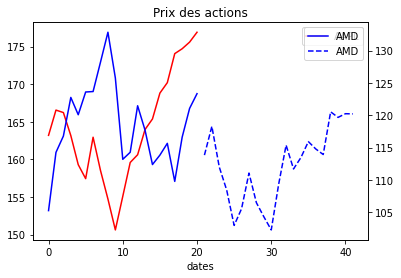

In [163]:
from pandas import DataFrame
import matplotlib.pyplot as plt


# On créé une nouvelle figure pour afficher le premier graphique
plt.Figure(figsize=(5,5), dpi=100)
ax = plt.subplot(111)
ax.yaxis.label.set_color('red')
# On recupere les dates et les prix de l'actif 1
dates = [index for index in range(len(best_choice["chart_reference"]))]
prix = best_choice["chart_reference"]

# On crée un DataFrame pendant pour le plot plus facilement
df = DataFrame({"dates":dates,best_choice["actif_reference"]:prix},columns=[best_choice["actif_reference"],'dates'])
# On regroupe les prix par dates
df = df[['dates',best_choice["actif_reference"]]].groupby('dates').sum()
# On affiche le dataframe
df.plot(kind='line', legend=True, ax=ax, color='r')


ax2 = ax.twinx()
ax2.yaxis.label.set_color('b')
# On recupere les dates et les prix de l'actif 2
prix = best_choice["chart_comparison"]

# On crée un DataFrame pendant pour le plot plus facilement
df = DataFrame({"dates":dates,best_choice["actif_comparaison"]:prix},columns=[best_choice["actif_comparaison"],'dates'])

# On regroupe les prix par dates
df = df[['dates',best_choice["actif_comparaison"]]].groupby('dates').sum()
# On affiche le dataframe
df.plot(kind='line', legend=True, ax=ax2, color='b')

# On recupere les dates et les prix de l'actif 2
prix = best_choice["current_data"]
dates = [index for index in range(len(best_choice["chart_reference"]),len(best_choice["chart_reference"])+len(best_choice["chart_reference"]))]
# On crée un DataFrame pendant pour le plot plus facilement
df = DataFrame({"dates":dates,best_choice["actif_comparaison"]:prix},columns=[best_choice["actif_comparaison"],'dates'])

# On regroupe les prix par dates
df = df[['dates',best_choice["actif_comparaison"]]].groupby('dates').sum()
# On affiche le dataframe
df.plot(linestyle='dashed',kind='line', legend=True, ax=ax2, color='b')

ax.set_title('Prix des actions')

plt.show()